In [1]:
# Project Image Filtering and Hybrid Images Stencil Code
# Based on previous and current work
# by James Hays for CSCI 1430 @ Brown and
# CS 4495/6476 @ Georgia Tech
import numpy as np
from numpy import pi, exp, sqrt
from skimage import io, img_as_ubyte, img_as_float32
from skimage.transform import rescale

def my_imfilter(img: np.ndarray, kernal: np.ndarray):
    
    assert kernal.size//2 !=0
#     print(np.floor(kernal.shape[0]/2),np.floor(kernal.shape[1]/2))
    if np.size(img.shape) != 2 :
#     filtered = np.zeros((img.shape[0]+int(np.floor(kernal.shape[0]/2)) ,img.shape[1]+int(np.floor(kernal.shape[1]/2)), img.shape[2]))
        filtered = np.zeros((img.shape[0] ,img.shape[1], img.shape[2]))
        print(img.shape[2])
        for r in range( img.shape[2]):
            z = np.lib.pad(img[:,:,r] , (int(np.floor(kernal.shape[0]/2)),int(np.floor(kernal.shape[1]/2))), 'constant', constant_values=(0 ,0))
            print(z.shape)
            for i in range(int(np.floor(kernal.shape[0]/2)),img.shape[0]):
                for j in range(int(np.floor(kernal.shape[1]/2)),img.shape[1]):
                    filtered[i,j,r] = np.sum(np.multiply(kernal , z[i-int(np.floor(kernal.shape[0]/2)):i+int(np.floor(kernal.shape[0]/2))+1 , j-int(np.floor(kernal.shape[1]/2)):j+int(np.floor(kernal.shape[1]/2))+1]))



    else:
        
        filtered = np.zeros((img.shape[0]+int(np.floor(kernal.shape[0]/2)) ,img.shape[1]+int(np.floor(kernal.shape[1]/2))))
        z = np.lib.pad(img , (int(np.floor(kernal.shape[0]/2)),int(np.floor(kernal.shape[1]/2))), 'constant', constant_values=(0 ,0))
        for i in range(int(np.floor(kernal.shape[0]/2)),img.shape[0]):
            for j in range(int(np.floor(kernal.shape[1]/2)),img.shape[1]):
                filtered[i,j] =np.sum(np.multiply(kernal , z[i-int(np.floor(kernal.shape[0]/2)):i+int(np.floor(kernal.shape[0]/2))+1 , j-int(np.floor(kernal.shape[0]/2)):j+int(np.floor(kernal.shape[0]/2))+1]))
        #             [np.nonzero(filtered)]
    return  filtered




In [2]:
# This function can be implemented using a double loop but since we 
# have numpy we can try it without loops 
# check np.meshgrid https://www.geeksforgeeks.org/numpy-meshgrid-function/
def create_gaussian_filter(ksize, sigma):
    assert(ksize%2 == 1)
    center = ksize//2
    kernel = [np.exp(-(i-center)**2/sigma**2)*np.exp(-(j-center)**2/sigma**2) for i in range(ksize) for j in range(ksize)]
    kernel = np.array(kernel)/ksize**2
    kernel = kernel
    kernel.resize(ksize,ksize)
    return kernel

In [3]:
import cv2
import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt
from scipy import signal


In [4]:
def gen_hybrid_image(image1: np.ndarray, image2: np.ndarray, cutoff_frequency: float):
    assert image1.shape == image2.shape

  # Steps:
  # (1) Remove the high frequencies from image1 by blurring it. The amount of
  #     blur that works best will vary with different image pairs
  # generate a gaussian kernel with mean=0 and sigma = cutoff_frequency,
  # Just a heads up but think how you can generate 2D gaussian kernel from 1D gaussian kernel
#     kernel = create_gaussian_filter(ksize = 5, sigma =cutoff_frequency )
    kernel = cv2.getGaussianKernel(5 , cutoff_frequency)
    kernel = np.outer(kernel, kernel.transpose())
    kernel_ft = fftpack.fft2(kernel, shape=image1.shape[:2], axes=(0, 1))

  # Your code here:
    img_ft = fftpack.fft2(image1, axes=(0, 1))
    low_frequencies = signal.fftconvolve(image1, kernel[:, :, np.newaxis], mode='same')

    #low_frequencies = my_imfilter(image1 , kernel) # Replace with your implementation

  # (2) Remove the low frequencies from image2. The easiest way to do this is to
  #     subtract a blurred version of image2 from the original version of image2.
  #     This will give you an image centered at zero with negative values.
  # Your code here #
    img2_ft = fftpack.fft2(image2, axes=(0, 1))
    low_frequencies_2 = signal.fftconvolve(image2, kernel[:, :, np.newaxis], mode='same')
    high_frequencies = image2 - low_frequencies_2 # Replace with your implementation

#     high_frequencies = image2 - my_imfilter(image2 , kernel) # Replace with your implementation

  # (3) Combine the high frequencies and low frequencies
  # Your code here #
    hybrid_image = low_frequencies + high_frequencies # Replace with your implementation

  # (4) At this point, you need to be aware that values larger than 1.0
  # or less than 0.0 may cause issues in the functions in Python for saving
  # images to disk. These are called in proj1_part2 after the call to 
# gen_hybrid_image().
    np.clip(hybrid_image ,0 ,1)
  # One option is to clip (also called clamp) all values below 0.0 to 0.0, 
  # and all values larger than 1.0 to 1.0.
  # (5) As a good software development practice you may add some checks (assertions) for the shapes
  # and ranges of your results. This can be performed as test for the code during development or even
  # at production!

    return low_frequencies, high_frequencies, hybrid_image


In [5]:
def vis_hybrid_image(hybrid_image: np.ndarray):
    
    scales = 5
    scale_factor = 0.5
    padding = 5
    original_height = hybrid_image.shape[0]
    num_colors = 1 if hybrid_image.ndim == 2 else 3

    output = np.copy(hybrid_image)
    cur_image = np.copy(hybrid_image)
    for scale in range(2, scales+1):
        output = np.hstack((output, np.ones((original_height, padding, num_colors),
                                        dtype=np.float32)))
        # downsample image
        cur_image = rescale(cur_image, scale_factor, mode='reflect', multichannel =True)
        # pad the top to append to the output
        pad = np.ones((original_height-cur_image.shape[0], cur_image.shape[1],num_colors), dtype=np.float32)
        tmp = np.vstack((pad, cur_image))
        output = np.hstack((output, tmp))
        return output

def load_image(path):
    return img_as_float32(io.imread(path))

def save_image(path, im):
    return io.imsave(path, img_as_ubyte(im.copy()))


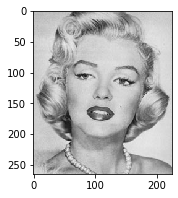

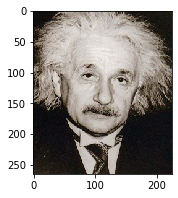

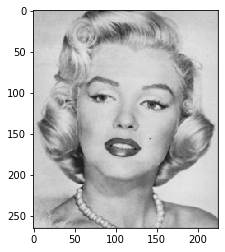

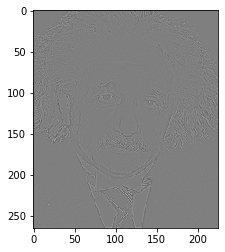

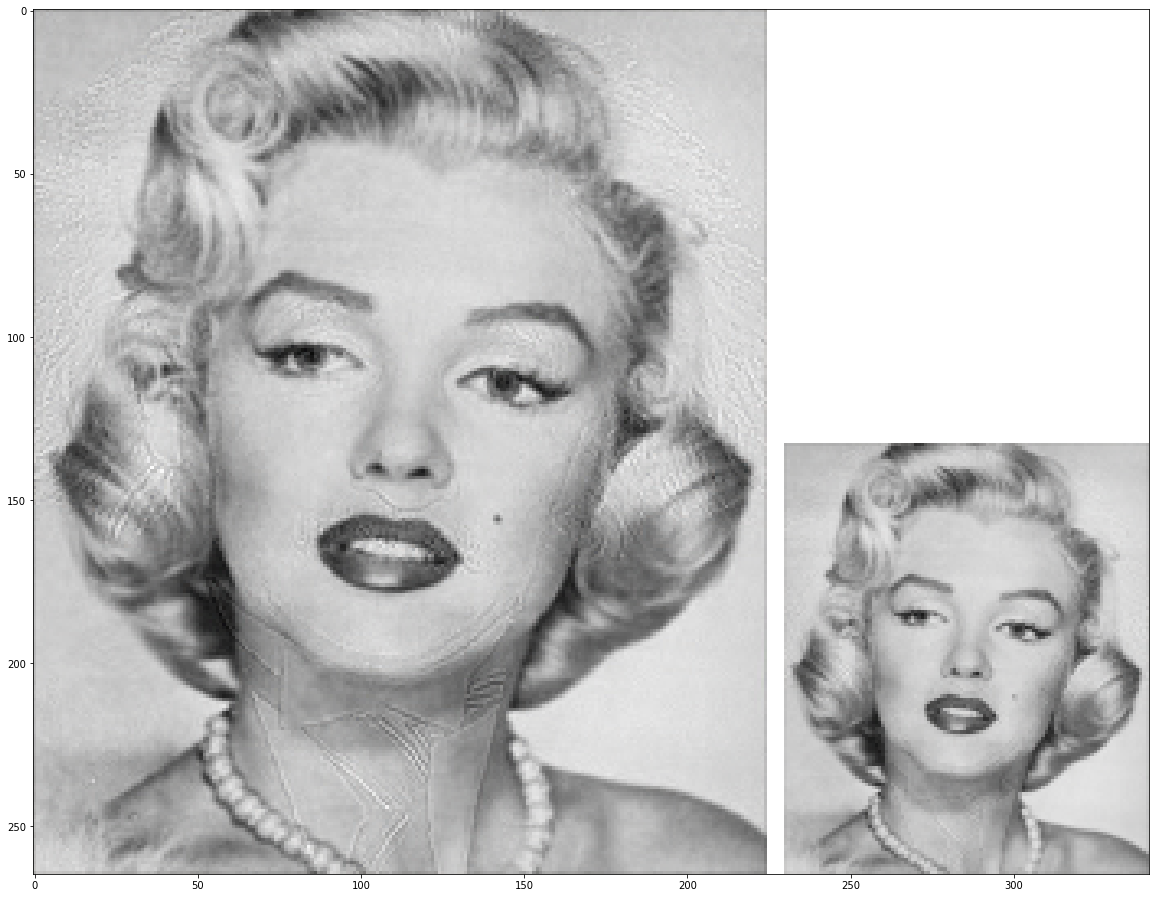

In [7]:
# Project Image Filtering and Hybrid Images - Generate Hybrid Image
# Based on previous and current work
# by James Hays for CSCI 1430 @ Brown and
# CS 4495/6476 @ Georgia Tech
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# from helpers import vis_hybrid_image, load_image, save_image, my_imfilter, gen_hybrid_image

# Before trying to construct hybrid images, it is suggested that you
# implement my_imfilter in helpers.py and then debug it using proj1_part1.py

# Debugging tip: You can split your python code and print in between
# to check if the current states of variables are expected or use a proper debugger.

## Setup
# Read images and convert to floating point format
image1 = load_image('../data/marilyn.bmp')
image2 = load_image('../data/einstein.bmp')

# display the dog and cat images
plt.figure(figsize=(3,3))
plt.imshow((image1*255).astype(np.uint8))
plt.figure(figsize=(3,3))
plt.imshow((image2*255).astype(np.uint8))

# For your write up, there are several additional test cases in 'data'.
# Feel free to make your own, too (you'll need to align the images in a
# photo editor such as Photoshop).
# The hybrid images will differ depending on which image you
# assign as image1 (which will provide the low frequencies) and which image
# you asign as image2 (which will provide the high frequencies)

## Hybrid Image Construction ##
# cutoff_frequency is the standard deviation, in pixels, of the Gaussian#
# blur that will remove high frequencies. You may tune this per image pair
# to achieve better results.
cutoff_frequency = .5
low_frequencies, high_frequencies, hybrid_image = gen_hybrid_image(image1, image2, cutoff_frequency)

## Visualize and save outputs ##
plt.figure()
plt.imshow((low_frequencies*255).astype(np.uint8))
plt.figure()
plt.imshow(((high_frequencies+0.5)*255).astype(np.uint8))
vis = vis_hybrid_image(hybrid_image)
plt.figure(figsize=(20, 20))
plt.imshow(vis)

save_image('../results/low_frequencies.jpg', low_frequencies)
save_image('../results/high_frequencies.jpg', high_frequencies+0.5)
save_image('../results/hybrid_image.jpg', hybrid_image)
save_image('../results/hybrid_image_scales.jpg', vis)
